In [1]:
%load_ext autoreload
%autoreload 2

#from configs.RecursiveVPSDE.LSTM_fSin.recursive_LSTM_PostMeanScaledScore_fSin_T256_H05_tl_5data import get_config as get_config
from configs.RecursiveVPSDE.LSTM_fSin.recursive_LSTM_PostMeanScore_fSin_T256_H05_tl_5data import get_config as get_config
#from configs.RecursiveVPSDE.LSTM_fSin.recursive_LSTM_fSinWithPosition_T256_H05_tl_5data import get_config as get_config

from configs import project_config
import numpy as np
import torch
import os
from src.generative_modelling.models.ClassVPSDEDiffusion import VPSDEDiffusion

import matplotlib.pyplot as plt

In [2]:
config = get_config()
print(config.beta_min)
print(config.max_diff_steps)
if config.has_cuda:
    device = int(os.environ["LOCAL_RANK"])
else:
    print("Using CPU\n")
    device = torch.device("cpu")

diffusion = VPSDEDiffusion(beta_max=config.beta_max, beta_min=config.beta_min)

max_diff_steps = config.max_diff_steps
sample_eps = config.sample_eps
ts_step = 1 / config.ts_length

Nepoch = 960#config.max_epochs[0]
# Fix the number of training epochs and training loss objective loss

0.0
10000
Using CPU



In [3]:
Ndiff = config.max_diff_steps
if "PMS" in config.scoreNet_trained_path:
    type = "PMS"
elif "PM" in config.scoreNet_trained_path:
    type = "PM"
else:
    type = ""
es = 0
Ndiff = 10000
file_path = f"/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TS{type}_ES{es}_fSin_DriftEvalExp_{Nepoch}Nep_{config.loss_factor}LFactor_10MeanRev_{Ndiff}DiffSteps_"
drift_est = torch.load(file_path+"driftEst")[:,:,:].permute(1,2,0)
prevPaths = torch.load(file_path+"prevPaths")[0,:]
if type == "":
    type = "Standard"
print(type)

PM


In [4]:
drift_est.shape

torch.Size([332, 10000, 50])

In [5]:
import statsmodels.tsa.stattools as smt
def effective_sample_size(x):
    N = x.shape[0]
    acf = smt.acf(x, nlags=N//2, fft=True)  # Compute autocorrelations
    M = np.where(acf < 0)[0][0] if np.any(acf < 0) else len(acf)  # Truncate at first negative autocorrelation
    V = 1 + 2 * np.sum(acf[1:M])  # Sum autocorrelations
    return N / V  # Compute ESS

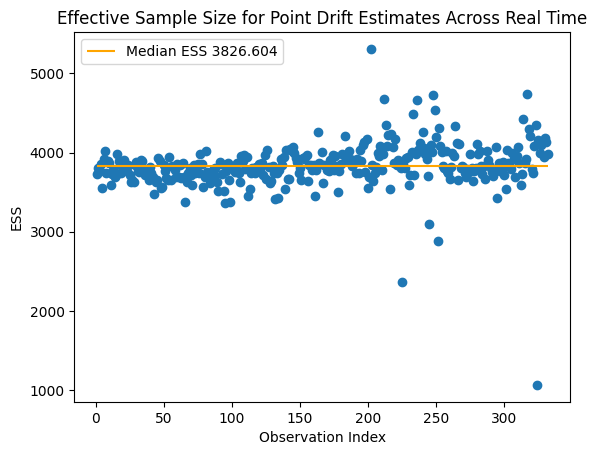

In [6]:
ESS = []
for t in range(drift_est.shape[0]):
    means = drift_est[t, :, :].mean(dim=-1)
    ESS.append(effective_sample_size(means))
plt.scatter(np.arange(1, drift_est.shape[0]+1), ESS)
plt.hlines(y=np.quantile(ESS, 0.5), xmin=1, xmax=332, color="orange", label=f"Median ESS {round(np.quantile(ESS, 0.5), 3)}")
plt.xlabel("Observation Index")
plt.ylabel("ESS")
plt.title("Effective Sample Size for Point Drift Estimates Across Real Time")
plt.legend()
plt.show()
plt.close()
# Verify Autocorr of remaining samples
for t in range(drift_est.shape[0]):
    x = drift_est[t, ::4000, :].mean(dim=-1)
    acf = smt.acf(x, nlags=x.shape[0]//2, fft=True)  # Compute auto-correlations
    break

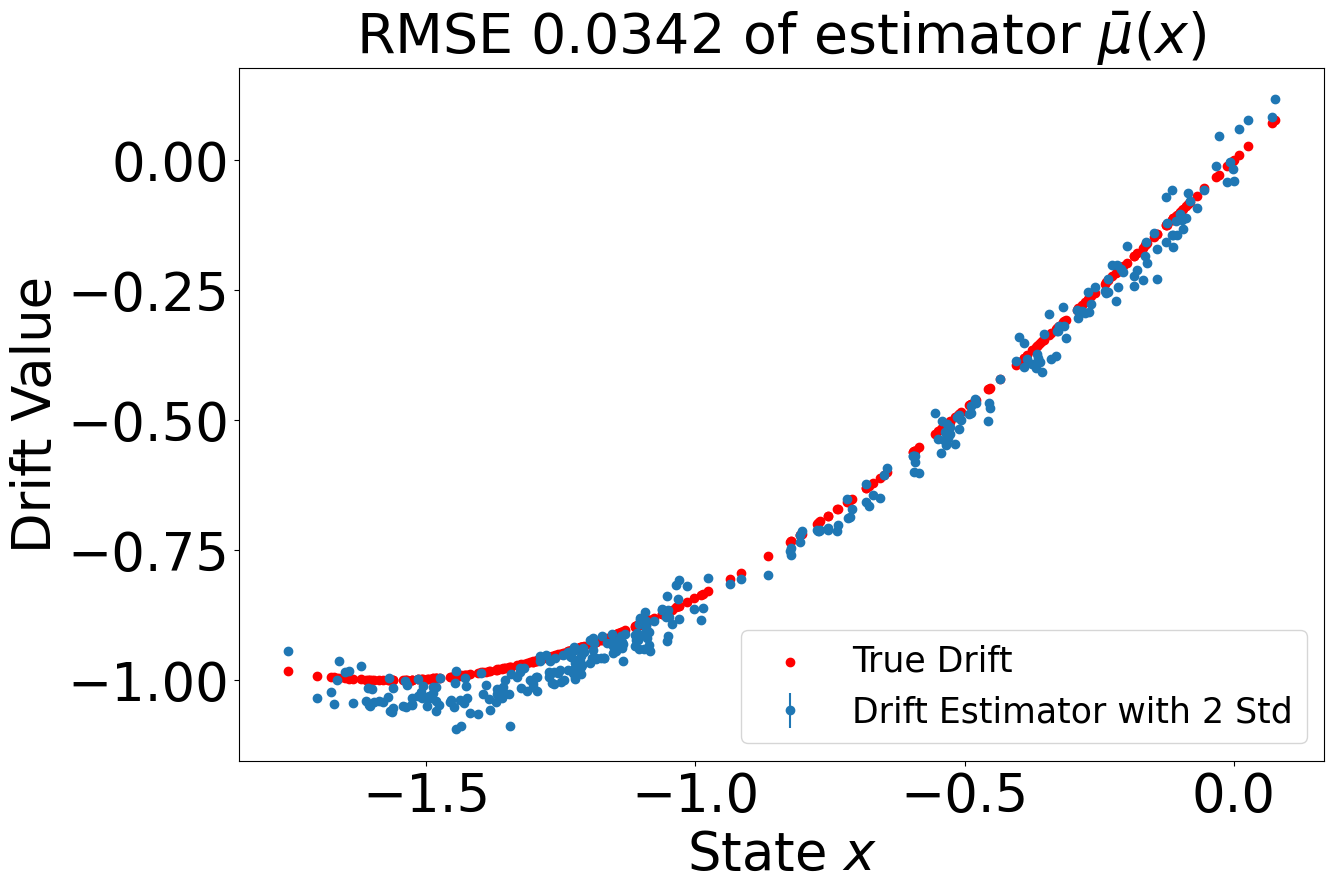

In [8]:
#unravel_drift_est=drift_est[:,-100::,:].permute((1,0,2)).reshape(100, drift_est.shape[0]*drift_est.shape[-1])
#prec_est_drift = torch.linalg.inv(unravel_drift_est.cov())
#ones = torch.ones((prec_est_drift.shape[0],1))
#denom = ones.T@prec_est_drift@ones
#num = prec_est_drift@ones
#weights = num/denom
#estimator = (trial_est*weights.flatten()).sum(dim=-1).numpy()
estimator = drift_est[:,-9000::4000,:].mean(dim=(1,2)).numpy()
std = drift_est[:,-9000::4000,:].std(dim=(1,2)).numpy()
plot_drift_estimator(mean=estimator, stds=0*std, numpy_Xs=prevPaths.numpy(), type=type, toSave=False)

In [7]:
def plot_drift_estimator(mean, stds, numpy_Xs, type, toSave:bool = True):
    fig, ax = plt.subplots(figsize=(14,9))
    rmse = np.power(np.mean(np.power(np.sin(numpy_Xs) - mean, 2)), 0.5)
    ax.scatter(numpy_Xs, np.sin(numpy_Xs), color="red", label="True Drift")
    ax.errorbar(numpy_Xs, mean, fmt="o",yerr=2*stds, label="Drift Estimator")
    ax.set_title(rf"OOS RMSE {round(rmse,5)} of Diffusion Model Estimator", fontsize=40)
    ax.tick_params(labelsize=38)
    ax.set_xlabel("State $X$", fontsize=38)
    ax.set_ylabel("Drift Value", fontsize=38)
    ax.legend(loc="lower right", fontsize=25)
    if toSave:
        plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/LSTM_fSin_{type}.png", bbox_inches='tight')
    plt.show()
    plt.close()

In [13]:
drift_est.shape

torch.Size([256, 10000, 500])

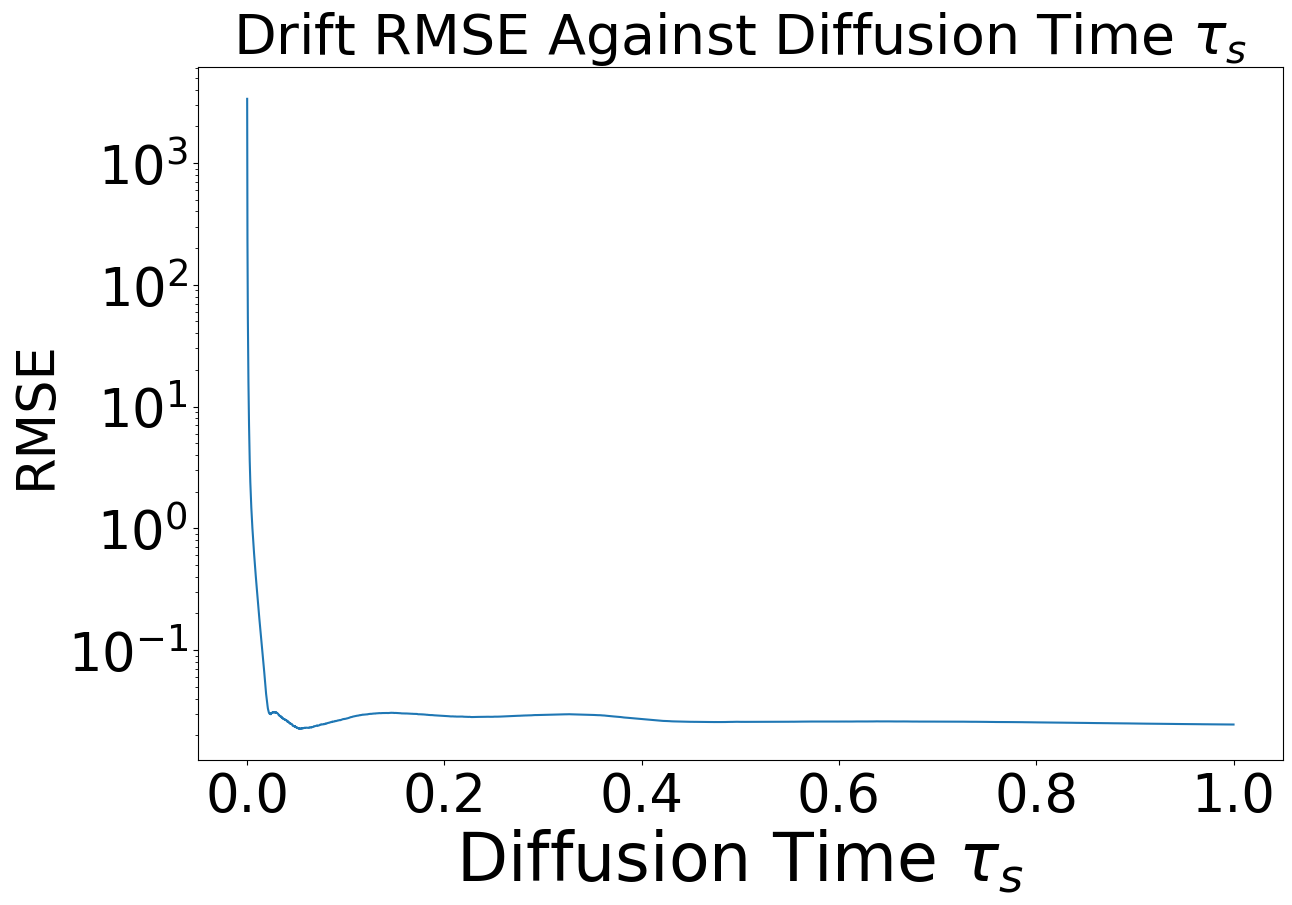

In [14]:
true_drifts = np.sin(prevPaths).unsqueeze(-1)
diff_mses = (true_drifts - drift_est.mean(dim=-1).numpy()).permute(1,0).pow(2).sum(dim=-1) / (drift_est.shape[0])
diff_rmses = diff_mses.pow(0.5)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(np.linspace(config.sample_eps, config.end_diff_time, drift_est.shape[1]), diff_rmses)
ax.set_title(r"Drift RMSE Against Diffusion Time $\tau_{s}$", fontsize=40)
ax.tick_params(labelsize=38)
plt.yscale("log")
ax.set_xlabel(r"Diffusion Time $\tau_{s}$", fontsize=48)
ax.set_ylabel(r"RMSE", fontsize=38)
plt.savefig(f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/LSTM_fSin_{type}_RMSEs.png",  bbox_inches='tight')

In [16]:
print(diff_rmses.argmin(), diff_rmses.min())

tensor(540) tensor(0.0226)


In [17]:
mu_hats = drift_est.mean(dim=-1).numpy()
print(mu_hats.shape)
per_diff_stds = drift_est.std(dim=-1).numpy()

(256, 10000)


In [18]:
for j in range(0, 100, -1):
    plot_drift_estimator(mean=mu_hats[:,j], stds=per_diff_stds[:, j], numpy_Xs=prevPaths.numpy(), type="type", toSave=False)

In [19]:
start_diff_idx = int(mu_hats.shape[1]*0.1)
end_diff_idx = int(mu_hats.shape[1]*1)
mu_hats = drift_est[:, start_diff_idx:end_diff_idx, :].reshape(drift_est.shape[0], drift_est.shape[-1]*(end_diff_idx-start_diff_idx)).mean(dim=-1).numpy()
stds = drift_est[:, start_diff_idx:end_diff_idx, :].reshape(drift_est.shape[0], drift_est.shape[-1]*(end_diff_idx-start_diff_idx)).std(dim=-1).numpy()

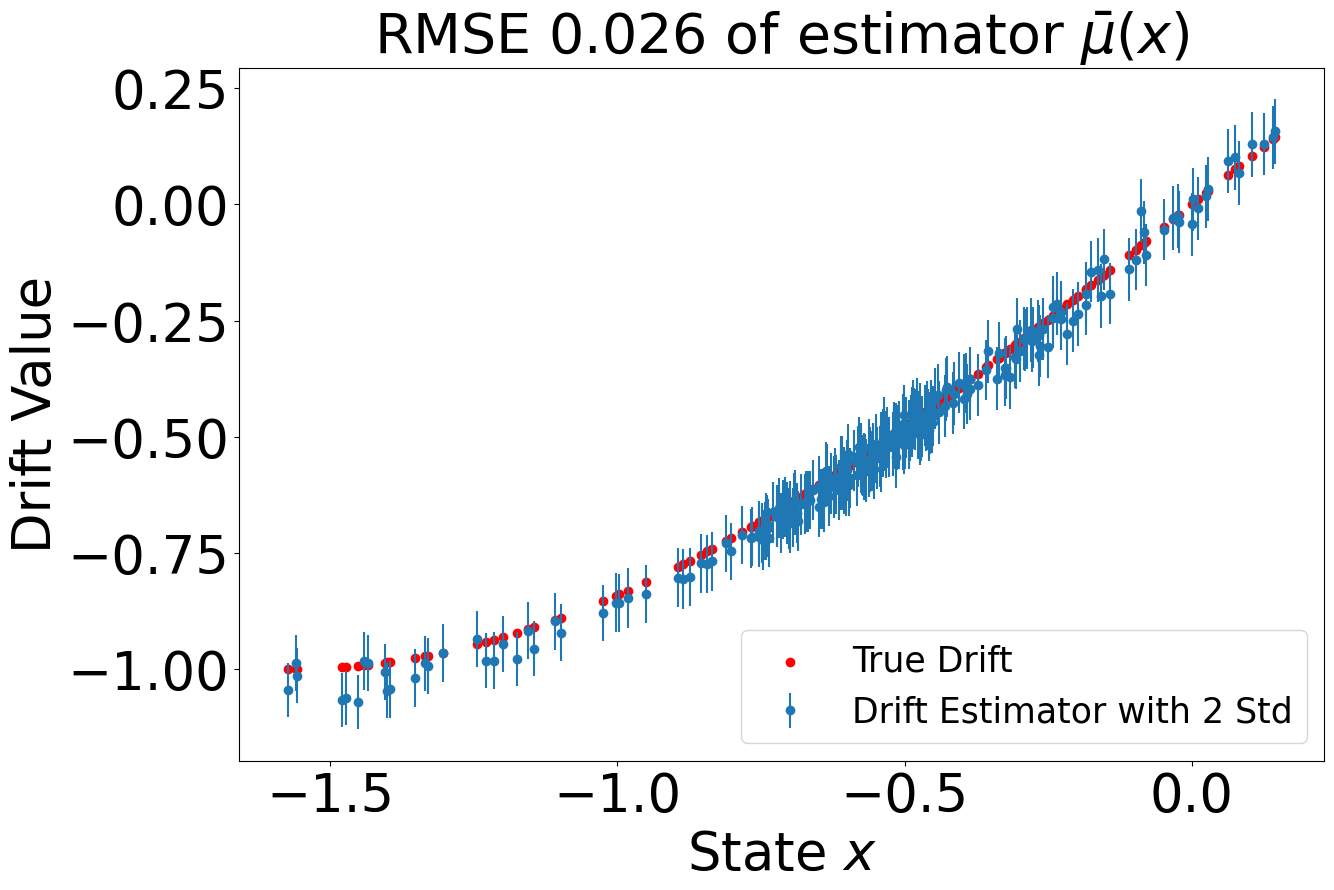

0.0325792


In [20]:
plot_drift_estimator(mean=mu_hats, stds=stds, numpy_Xs=prevPaths.numpy(), type=type, toSave=True)
print(np.mean(stds))